In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np

torch.set_default_device("cuda")

seed = 404
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
generator = torch.Generator("cuda").manual_seed(seed)

# 1. MNIST 데이터셋 다운로드 및 전처리
transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size], generator)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, generator=generator)

In [2]:
# 2. MLP 모델 정의 (원-핫 레이블을 이미지로 디코딩)
class LabelToImageMLP(nn.Module):
    def __init__(self):
        super(LabelToImageMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# 모델 인스턴스화 및 손실 함수, 옵티마이저 정의
model = LabelToImageMLP()

# 2. Conditional VAE 모델 정의
class ConditionalVAE(nn.Module):
    def __init__(self, pretrained_model):
        super(ConditionalVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 + 10, 128),  # 28*28 (image) + 10 (one-hot label)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, 10)
        self.fc_logvar = nn.Linear(64, 10)
        self.decoder = pretrained_model
    
    def encode(self, x, labels):
        x = torch.cat([x, labels], dim=1)
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, labels):
        z = 0.1 * z + labels
        return self.decoder(z)
    
    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, labels), mu, logvar

# Conditional VAE 모델 인스턴스화 및 손실 함수, 옵티마이저 정의
cvae_model = ConditionalVAE(model)
optimizer = optim.Adam(cvae_model.parameters(), lr=0.001)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [3]:
# 3. 일정 epoch 동안 모델 학습
num_epochs = 20
train_losses = []
val_losses = []

def one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels].cuda()

for epoch in range(num_epochs):
    cvae_model.train()
    train_loss = 0
    for data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        labels_one_hot = one_hot(labels, 10)
        data = data.view(-1, 28*28).cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae_model(data, labels_one_hot)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    cvae_model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, labels in val_loader:
            labels_one_hot = one_hot(labels, 10)
            data = data.view(-1, 28*28).cuda()
            recon_batch, mu, logvar = cvae_model(data, labels_one_hot)
            loss = loss_function(recon_batch, data, mu, logvar)
            val_loss += loss.item()
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/20: 100%|██████████| 750/750 [00:07<00:00, 101.19it/s]


Epoch [1/20], Train Loss: 166.2067, Val Loss: 138.9189


Epoch 2/20: 100%|██████████| 750/750 [00:07<00:00, 103.27it/s]


Epoch [2/20], Train Loss: 130.8018, Val Loss: 125.2127


Epoch 3/20: 100%|██████████| 750/750 [00:07<00:00, 104.76it/s]


Epoch [3/20], Train Loss: 122.2635, Val Loss: 119.7233


Epoch 4/20: 100%|██████████| 750/750 [00:07<00:00, 103.01it/s]


Epoch [4/20], Train Loss: 117.5773, Val Loss: 116.0572


Epoch 5/20: 100%|██████████| 750/750 [00:07<00:00, 104.61it/s]


Epoch [5/20], Train Loss: 114.3589, Val Loss: 113.2791


Epoch 6/20: 100%|██████████| 750/750 [00:07<00:00, 107.08it/s]


Epoch [6/20], Train Loss: 112.2543, Val Loss: 111.7996


Epoch 7/20: 100%|██████████| 750/750 [00:07<00:00, 106.75it/s]


Epoch [7/20], Train Loss: 110.6723, Val Loss: 110.3061


Epoch 8/20: 100%|██████████| 750/750 [00:07<00:00, 106.10it/s]


Epoch [8/20], Train Loss: 109.2863, Val Loss: 108.7844


Epoch 9/20: 100%|██████████| 750/750 [00:07<00:00, 106.51it/s]


Epoch [9/20], Train Loss: 108.2317, Val Loss: 108.9321


Epoch 10/20: 100%|██████████| 750/750 [00:06<00:00, 107.47it/s]


Epoch [10/20], Train Loss: 107.2896, Val Loss: 107.6089


Epoch 11/20: 100%|██████████| 750/750 [00:07<00:00, 106.96it/s]


Epoch [11/20], Train Loss: 106.5651, Val Loss: 106.7280


Epoch 12/20: 100%|██████████| 750/750 [00:07<00:00, 105.67it/s]


Epoch [12/20], Train Loss: 105.8901, Val Loss: 106.6235


Epoch 13/20: 100%|██████████| 750/750 [00:07<00:00, 106.41it/s]


Epoch [13/20], Train Loss: 105.2043, Val Loss: 105.9527


Epoch 14/20: 100%|██████████| 750/750 [00:07<00:00, 106.76it/s]


Epoch [14/20], Train Loss: 104.5644, Val Loss: 104.7990


Epoch 15/20: 100%|██████████| 750/750 [00:06<00:00, 107.23it/s]


Epoch [15/20], Train Loss: 103.9156, Val Loss: 104.7415


Epoch 16/20: 100%|██████████| 750/750 [00:07<00:00, 105.69it/s]


Epoch [16/20], Train Loss: 103.3290, Val Loss: 104.0018


Epoch 17/20: 100%|██████████| 750/750 [00:07<00:00, 106.80it/s]


Epoch [17/20], Train Loss: 102.8817, Val Loss: 103.8684


Epoch 18/20: 100%|██████████| 750/750 [00:07<00:00, 106.29it/s]


Epoch [18/20], Train Loss: 102.3623, Val Loss: 103.2008


Epoch 19/20: 100%|██████████| 750/750 [00:07<00:00, 107.07it/s]


Epoch [19/20], Train Loss: 101.9825, Val Loss: 103.0652


Epoch 20/20: 100%|██████████| 750/750 [00:07<00:00, 106.05it/s]


Epoch [20/20], Train Loss: 101.6848, Val Loss: 102.9841


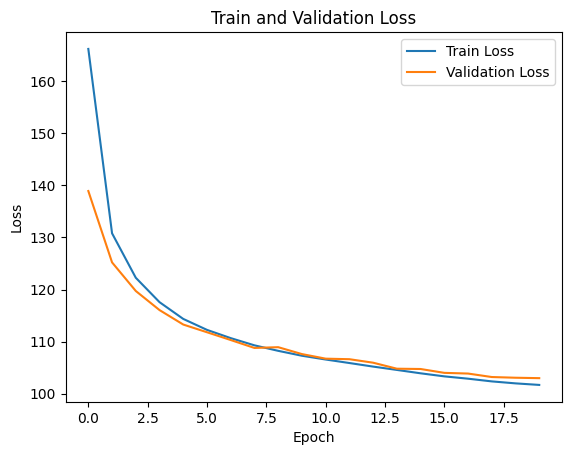

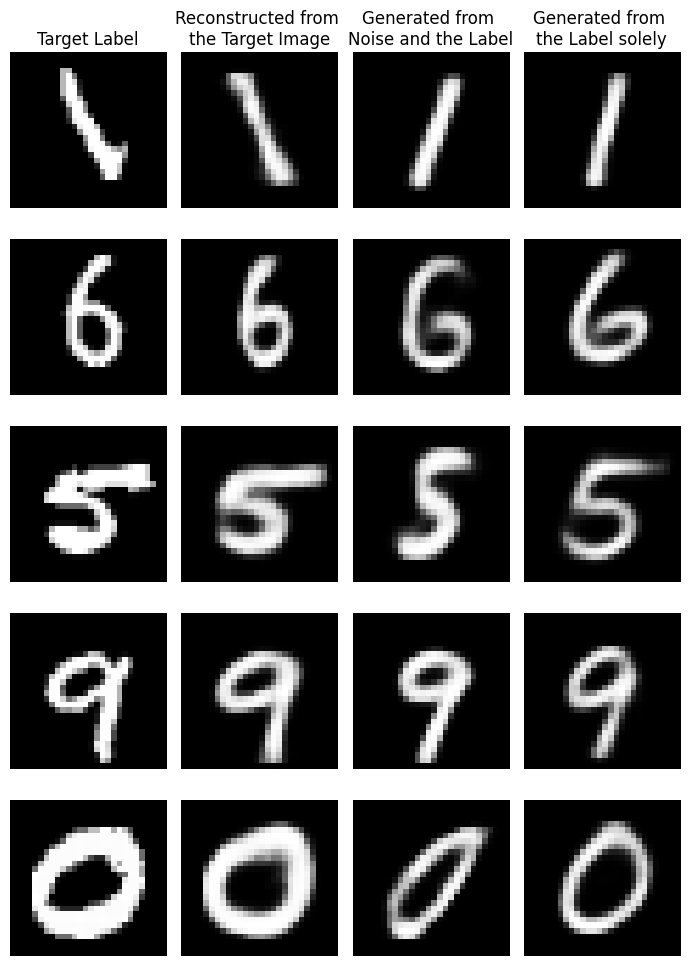

In [4]:
# 4. 학습 종료 후 에러 그래프 시각화
plt.figure()
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# 5. Validation set에서 몇 개의 레이블을 추출하여 원-핫 인코딩된 레이블을 통해 이미지를 생성하고 시각화
cvae_model.eval()
with torch.no_grad():
    # Validation set의 오토인코딩 결과 시각화
    data_iter = iter(val_loader)
    data, labels = next(data_iter)
    labels = one_hot(labels, 10)
    recon_batch, mu, logvar = cvae_model(data.view(-1, 28*28).cuda(), labels)
    
    fig, axes = plt.subplots(5, 4, figsize=(7, 10))
    axes[0, 0].set_title('Target Label')
    axes[0, 1].set_title('Reconstructed from \nthe Target Image')
    for i in range(5):
        axes[i, 0].imshow(data[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(recon_batch[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[i, 1].axis('off')
    
    # Gaussian noise와 label로 생성한 이미지 시각화
    z = torch.randn(5, 10)
    generated_images = cvae_model.decode(z, labels[:5])
    axes[0, 2].set_title('Generated from \nNoise and the Label')
    for i in range(5):
        axes[i, 2].imshow(generated_images[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[i, 2].axis('off')

    generated_images = cvae_model.decode(0.0 * z, labels[:5])
    axes[0, 3].set_title('Generated from \nthe Label solely')
    for i in range(5):
        axes[i, 3].imshow(generated_images[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()